In [2]:
# enable CUDA https://medium.com/@leennewlife/how-to-setup-pytorch-with-cuda-in-windows-11-635dfa56724b
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
import torch
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.2.1+cu121
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver**********
CUDNN version: 8801

Copyright (c) 2005-2024 NVIDIA Corporation
Built on Tue_Feb_27_16:28:36_Pacific_Standard_Time_2024
Cuda compilation tools, release 12.4, V12.4.99
Build cuda_12.4.r12.4/compiler.33961263_0
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 3050 Laptop GPU


# GPU

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
# Imagenes
import PIL
from PIL import Image


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Dataset and Dataloader

In [93]:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# Implementación específica Pepe Cantoral: https://www.youtube.com/watch?v=x_cY9l1cwj0&t=2s con algunas modificaciones para retornar la clase como key
class Car_Dataset(Dataset):
    def __init__(self, data_paths_dict, masks_paths_dict=None, img_transforms=None, mask_transforms=None):
        '''
        data_paths_dict - train data paths
        masks_paths_dict - train masks paths
        '''
        self.keys = {'COVID-19':0, 'Non-COVID': 1, 'Normal': 2}
        self.train_data = data_paths_dict # X
        self.train_masks = masks_paths_dict # y

        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        # Lista de tuplas  (clase, filename)
        # ordenada para que esten en el mismo orden que las mascaras
        self.images = []
        self.images = [(key, file) for key, dir in self.train_data.items() for file in sorted(os.listdir(dir))]
        if masks_paths_dict:
            self.masks =  [(key, file) for key, dir in self.train_masks.items() for file in sorted(os.listdir(dir))]

    def __len__(self):
        # Asegurarnos que sea el mismo numero de imagenes que de mascaras, habiendo mascaras
        if self.train_masks is not None:
            assert len(self.images) == len(self.masks), f'El numero de imagenes en {self.train_masks} y {self.train_data} no coincide'
        return len(self.images)


    def __getitem__(self, idx):
        '''
        Regresa un elemento del dataset en la posición de index
        Con iter se pueden iterar todos los elementos del dataset

        '''
        key, name = self.images[idx]
        image_name = os.path.join(self.train_data[key],name)
        img = Image.open(image_name).convert('RGB') # .convert('RGB') RGB

        # Aplicar transformaciones 
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img = T.ToTensor()(img) # Default trasnformation
        
        # Si no existen máscaras, retorna solamente img (Validación)
        if self.train_masks is None:
            return img, self.keys[key]
        else:
            key, name = self.images[idx]
            mask_name = os.path.join(self.train_masks[key], name)
            mask = Image.open(mask_name).convert('L') # .convert('L') grayscale
            # Aplicar transformaciones 
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = T.ToTensor()(mask)
            # Normalizamos la mascara para que sean zeros y unos
            mask_max = mask.max().item()
            mask /= mask_max
            
        # La mascara si existe
        return img, mask, key

# Transformaciones

In [6]:

transform_data = T.Compose([
    T.Resize([224,224]),
    T.ToTensor()
])

# Dataloaders

In [7]:
TRAIN_PATH = {
        "COVID-19": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\COVID-19\images",
        "Non-COVID": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\Non-COVID\images",
        "Normal": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\Normal\images"
}
TRAIN_MASKS_PATH = {
        "COVID-19": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\COVID-19\lung masks",
        "Non-COVID": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\Non-COVID\lung masks",
        "Normal": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\Normal\lung masks"
}
TEST_PATH = {
        "COVID-19": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Test\COVID-19\lung masks",
        "Non-COVID": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Test\Non-COVID\lung masks",
        "Normal": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Test\Normal\lung masks"
}

In [8]:
full_dataset = Car_Dataset(TRAIN_PATH, TRAIN_MASKS_PATH,
                           img_transforms=transform_data,
                           mask_transforms=transform_data)

In [9]:
len(full_dataset)

21715

In [10]:
BATCH_SIZE = 32
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE
print(TRAIN_SIZE, VAL_SIZE)

17372 4343


In [11]:
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])
print(len(train_dataset), len(val_dataset))

17372 4343


In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
imgs, masks_paths_dict, key = next(iter(train_loader))
print(imgs.shape, masks_paths_dict.shape, key)

torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224]) ('COVID-19', 'Normal', 'Normal', 'Non-COVID', 'Normal', 'Non-COVID', 'Normal', 'Non-COVID', 'Normal', 'Normal', 'Normal', 'Normal', 'COVID-19', 'Non-COVID', 'COVID-19', 'Non-COVID', 'Non-COVID', 'Normal', 'COVID-19', 'Normal', 'Non-COVID', 'Normal', 'COVID-19', 'Normal', 'COVID-19', 'Normal', 'Non-COVID', 'COVID-19', 'Non-COVID', 'Normal', 'Non-COVID', 'Non-COVID')


# Lets see the data

In [14]:
for i, (x,y, key) in enumerate(train_loader):
    print(i, x.shape, y.shape, key)
    if i==10: break

0 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224]) ('COVID-19', 'Non-COVID', 'Non-COVID', 'COVID-19', 'Non-COVID', 'Normal', 'Non-COVID', 'Non-COVID', 'Normal', 'COVID-19', 'Normal', 'Non-COVID', 'COVID-19', 'COVID-19', 'Normal', 'Non-COVID', 'Non-COVID', 'Non-COVID', 'COVID-19', 'Non-COVID', 'Normal', 'Normal', 'Non-COVID', 'COVID-19', 'Non-COVID', 'COVID-19', 'COVID-19', 'Non-COVID', 'Non-COVID', 'Non-COVID', 'Normal', 'Non-COVID')
1 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224]) ('Non-COVID', 'Normal', 'Normal', 'Normal', 'COVID-19', 'COVID-19', 'Normal', 'COVID-19', 'Non-COVID', 'Non-COVID', 'Non-COVID', 'Normal', 'COVID-19', 'Non-COVID', 'COVID-19', 'Normal', 'COVID-19', 'Non-COVID', 'Normal', 'Non-COVID', 'Normal', 'Normal', 'COVID-19', 'Non-COVID', 'Non-COVID', 'Non-COVID', 'COVID-19', 'Non-COVID', 'Normal', 'COVID-19', 'Normal', 'Normal')
2 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224]) ('Normal', 'COVID-19', 'Non-COVID', 'COVID-19', 'COVID-

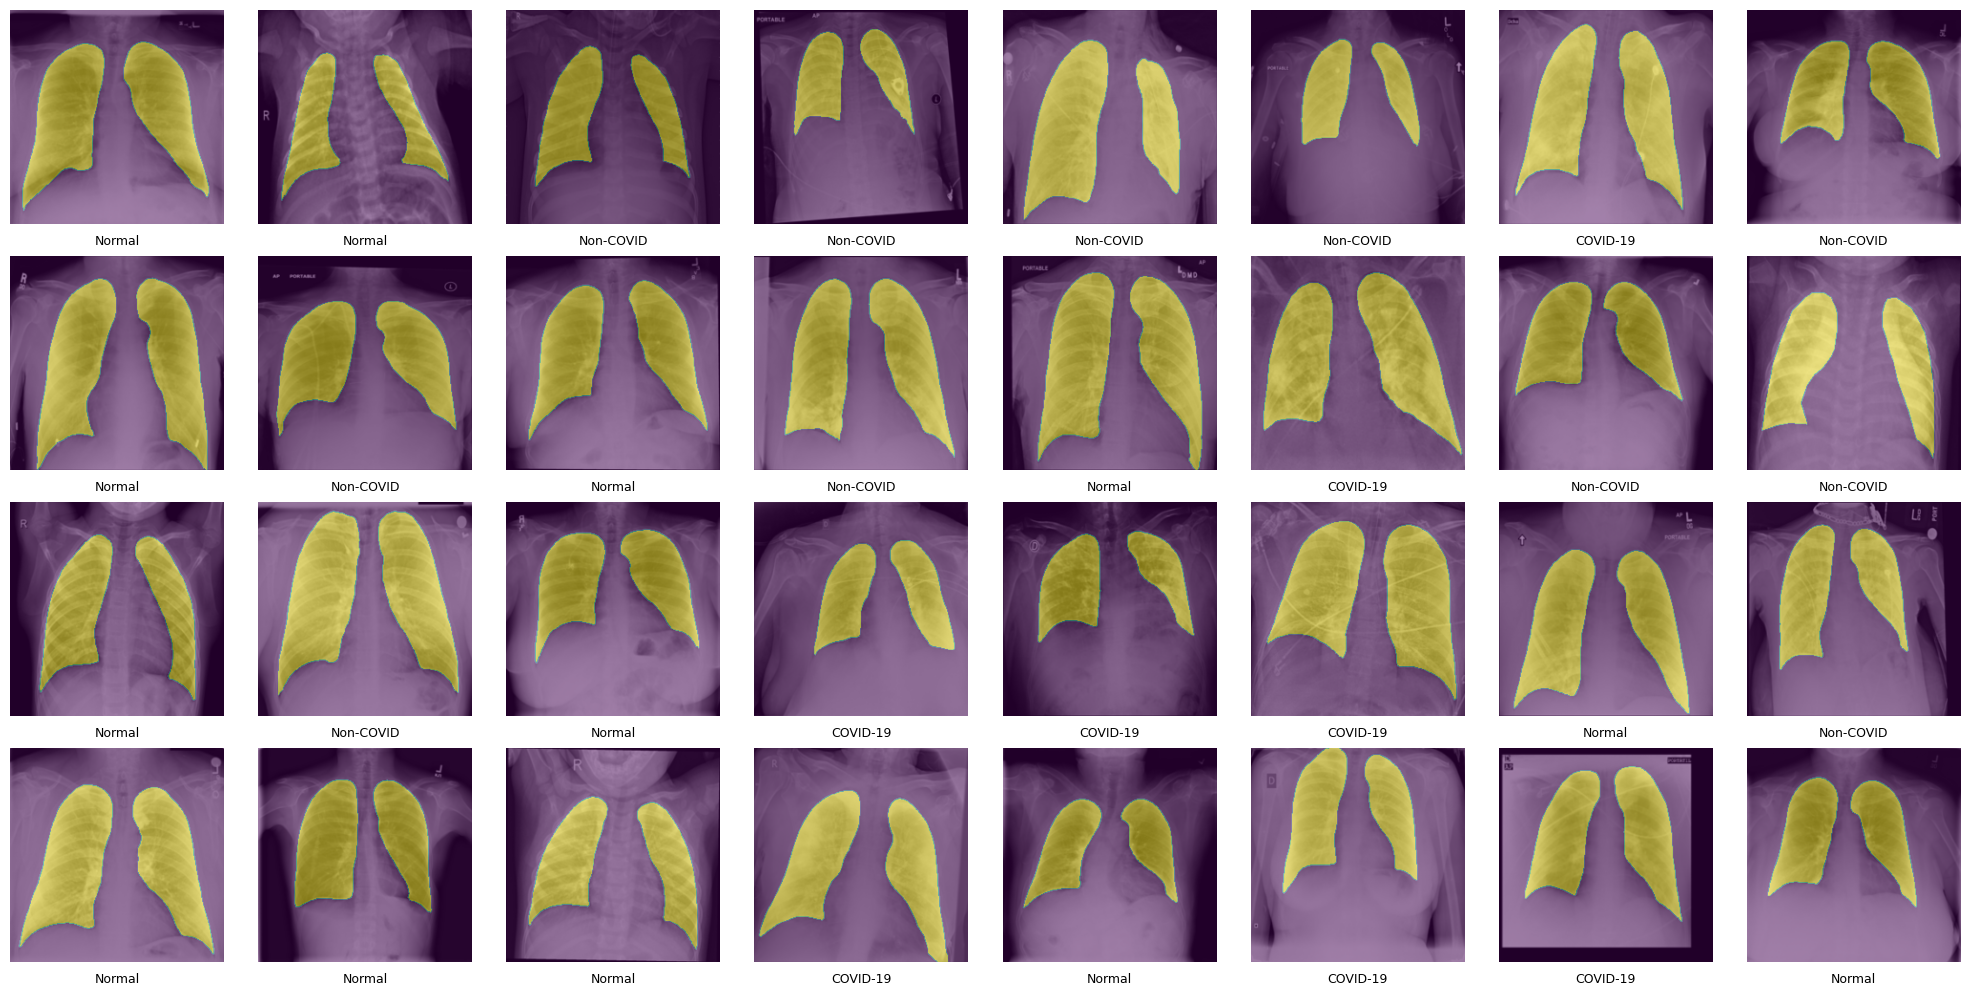

In [15]:
imgs, masks_paths_dict, keys = next(iter(train_loader))
def plot_mini_batch(imgs, masks, keys):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        # Filas, columnas y posición
        plt.subplot(4, 8, i+1)
        # De la posición i, pasa todos los canales
        # tensor = imgs[i,...]
        # Canales en la ultima posición (alto, ancho, canal)
        img=imgs[i,...].permute(1,2,0).numpy() 
        mask = masks[i,...].permute(1,2,0).numpy()
        key = keys[i]
        # Muestra la imagen utilizando matplotlib.
        plt.imshow(img)
        # Muestra la máscara encima de la imagen con transparencia (alpha=0.5),
        # permitiendo visualizar tanto la imagen como la máscara simultáneamente.
        plt.imshow(mask, alpha=0.5)
        # Desactiva los ejes para una visualización más limpia.
        plt.axis('Off')
        # Nombre de la clase
        plt.text(0.5, -0.1, str(key), fontsize=9, ha='center', transform=plt.gca().transAxes)
    # Ajusta el layout de la figura para evitar solapamientos entre las subfiguras.
    plt.tight_layout()
    plt.show()

plot_mini_batch(imgs, masks_paths_dict, keys)

# U-NET model

- Arquitectura tomada de este paper: https://arxiv.org/abs/1505.04597
- downsample -> 2 capa convolucional (3*3*n filtros), max pool, 2 capa convolucional, max pool, 2 capa convolucional, max pool
- up sample 

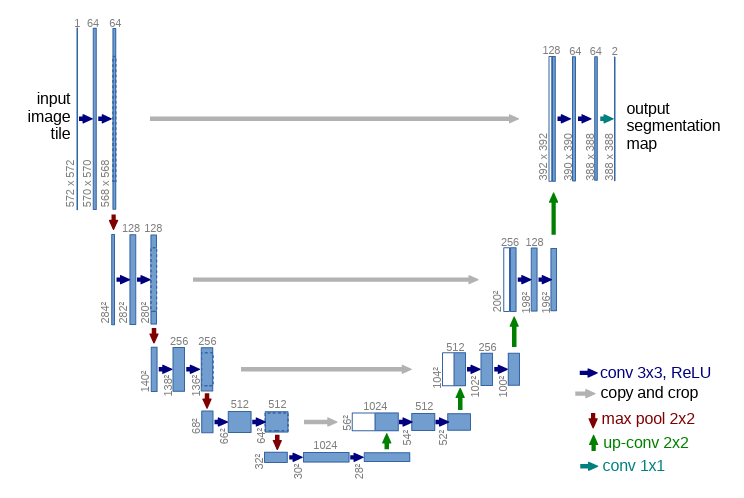

In [19]:
# 2 capa convolucional (3*3*n filtros)
class Conv_kernel_3_3(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        #  kernel_size=(3, 3)
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        return self.conv1(x)

In [20]:

class Conv_2_capas(nn.Module):
    '''
    2 capas convolucional (3*3*n filtros), Relu
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
                           Conv_kernel_3_3(channels_in, channels_out),
                           # Batch normalization para estabilizar y acelerar el proceso de aprendizaje: https://arxiv.org/abs/1502.03167
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
                           Conv_kernel_3_3(channels_out, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
                            )
    def forward(self, x):
        return self.double_conv(x)

In [21]:
# down convolution Max pool 2x2 -> 2 capas convolucional (3*3*n filtros), Relu 
class Down_Conv(nn.Module):
    '''
    Down convolution part
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
                        # Capa de agrupación máxima, reduce la dimensionalidad a la mitad
                        nn.MaxPool2d(2,2),
                        Conv_2_capas(channels_in, channels_out)
                        )
        # La SALIDA de la doble convolución se irá directamente al Up Convolution
    def forward(self, x):
        return self.encoder(x)

# Up convolution up-conv 2x2 -> 2 capas convolucional (3*3*n filtros), Relu     
class Up_Conv(nn.Module):
    '''
    Up convolution part
    '''
    def __init__(self,channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        # Duplicamos la muestra 16 píxeles más cercanos (4x4)
                        # esto permite mayor calidad
                        nn.Upsample(scale_factor=2, mode='bicubic'),
                        # Convolucion 1x1 para obtener el  La mitad de los canales llena, se va a concatenar con el down convolution
                        nn.Conv2d(channels_in, channels_in//2, kernel_size=1, stride=1)
                        )
        # Para la salida es la doble convolución de siempre
        self.decoder = Conv_2_capas(channels_in, channels_out)
    
    def forward(self, x1, x2):
        '''
        x1 - upsampled volume
        x2 - volume from down sample to concatenate
        '''
        x1 = self.upsample_layer(x1)
        # Copy and crop
        # dim 1 indica canales
        x = torch.cat([x2, x1],dim=1)
        return self.decoder(x)

In [22]:
class UNET(nn.Module):
    '''
    UNET model
    '''
    def __init__(self, channels_in, channels, num_classes):
        '''
        num_classes -> Canales de salida
        '''
        super().__init__()
        self.first_conv = Conv_2_capas(channels_in, channels) #64, (224, 224) (example considering we have a padding 1)
        self.down_conv1 = Down_Conv(channels, 2*channels) # 128, (112, 112)
        self.down_conv2 = Down_Conv(2*channels, 4*channels) # 256, (56, 56)
        self.down_conv3 = Down_Conv(4*channels, 8*channels) # 512, (28, 28)
        
        # La parte de en medio
        self.middle_conv = Down_Conv(8*channels, 16*channels) # 1024, 14, 14 
        
        self.up_conv1 = Up_Conv(16*channels, 8*channels)
        self.up_conv2 = Up_Conv(8*channels, 4*channels)
        self.up_conv3 = Up_Conv(4*channels, 2*channels)
        self.up_conv4 = Up_Conv(2*channels, channels)
        
        self.last_conv = nn.Conv2d(in_channels=channels, out_channels=num_classes, kernel_size=1, stride=1)  # 64 canales, 2 o 3 clases. 
       
    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)
        
        x5 = self.middle_conv(x4)
        
        u1 = self.up_conv1(x5, x4) # up convolution + concatenation
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)

        y_last_conv = self.last_conv(u4) # 64 canales, 2 clases escala de grises. 
        
        return y_last_conv

In [24]:
# comento para no gastar recursos al correr de nuevo
# def sample_test():
#     x = torch.randn((32, 3, 224, 224))
#     model = UNET(3, 64, 2)
#     return model(x)
# preds = sample_test()
# print(preds.shape)

torch.Size([32, 2, 224, 224])


# Métricas

In [45]:
# Evaluación de métricas
def metrics(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y, key in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            # toma la intersección de las dos clases por 2 y lo divide entre la suma de pixeles predicción y clase correcta
            # de 0 a 1, queremos maximizar esta métrica
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)
            val_cost = cost/len(loader)
            val_acc = float(correct)/total
        return val_cost, val_acc, dice, iou 

# Learning rate search
Función obtenida de https://www.youtube.com/watch?v=bBuIzwFKtZY

One cycle policy para encontrar learning rate optimo

In [38]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y, key) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)
        
        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies     

# Train loop

In [46]:
def train(model, optimiser, scheduler = None, epochs = 100, store_every = 25):
    model = model.to(device=device)
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.
        # para cada batch i (mb)
        for mb, (x, y, key) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            # y tiene forma 32, 1, 224,224, tiene un canal. con squeze queda 32,224,224
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            # Función de costo entropia cruzada
            cost = F.cross_entropy(input=scores, target=y)
            # Resetear los gradientes
            optimiser.zero_grad()
            cost.backward()
            # Optimización de parámetros
            optimiser.step()
            
            # Actualizar el leaning rate con el scheduler
            if scheduler: 
                scheduler.step()

            # quedarnos con el canal de mayor probabilidad   
            train_predictions = torch.argmax(scores, dim=1)
            # 224 *224 == 224*224 Valores 0 y 1 (lo que queremos segmentar)
            train_correct_num += (train_predictions == y).sum()
            train_total += torch.numel(train_predictions)
            # Acumulamos el costo
            train_cost_acum += cost.item()
            # Etapa de validación. Cada 25 iteraciones guardamos el accuracy de validación
            if mb%store_every == 0:
                # dice, intersection over union
                val_cost, val_acc, dice, iou = metrics(model, val_loader)
                # total de pixeles predichos de forma correcta / total de pixeles
                # Puede no ser el mejor métrico cuando la imagen segmentada sea muy pequeña (no es el caso)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb
                print(f'epoch: {epoch}, mb: {mb},',
                      f'train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice}, iou: {iou}')

# Train Segmentation model

In [39]:
# Busqueda del learning rate adecuado
# define the model and look for learning rate
torch.manual_seed(666)
# red de 4 canales base para usar menos recursos en esta fase
model = UNET(3, 4, 2)
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)

lg_lr, losses, accuracies = find_lr(model, optimiser_unet, start_val=1e-6, end_val=10)


cost:0.6837, lr: 0.0000, acc: 0.3436
cost:0.6780, lr: 0.0000, acc: 0.3578
cost:0.6783, lr: 0.0000, acc: 0.3550
cost:0.6781, lr: 0.0000, acc: 0.3514
cost:0.6808, lr: 0.0000, acc: 0.3477
cost:0.6776, lr: 0.0000, acc: 0.3514
cost:0.6819, lr: 0.0000, acc: 0.3530
cost:0.6650, lr: 0.0000, acc: 0.3714
cost:0.6705, lr: 0.0000, acc: 0.3557
cost:0.6788, lr: 0.0000, acc: 0.3583
cost:0.6804, lr: 0.0000, acc: 0.3448
cost:0.6778, lr: 0.0000, acc: 0.3576
cost:0.6726, lr: 0.0000, acc: 0.3604
cost:0.6770, lr: 0.0000, acc: 0.3569
cost:0.6746, lr: 0.0000, acc: 0.3573
cost:0.6729, lr: 0.0000, acc: 0.3604
cost:0.6732, lr: 0.0000, acc: 0.3619
cost:0.6754, lr: 0.0000, acc: 0.3598
cost:0.6808, lr: 0.0000, acc: 0.3552
cost:0.6670, lr: 0.0000, acc: 0.3672
cost:0.6830, lr: 0.0000, acc: 0.3480
cost:0.6789, lr: 0.0000, acc: 0.3524
cost:0.6784, lr: 0.0000, acc: 0.3594
cost:0.6755, lr: 0.0000, acc: 0.3566
cost:0.6805, lr: 0.0000, acc: 0.3513
cost:0.6810, lr: 0.0000, acc: 0.3530
cost:0.6776, lr: 0.0000, acc: 0.3547
c

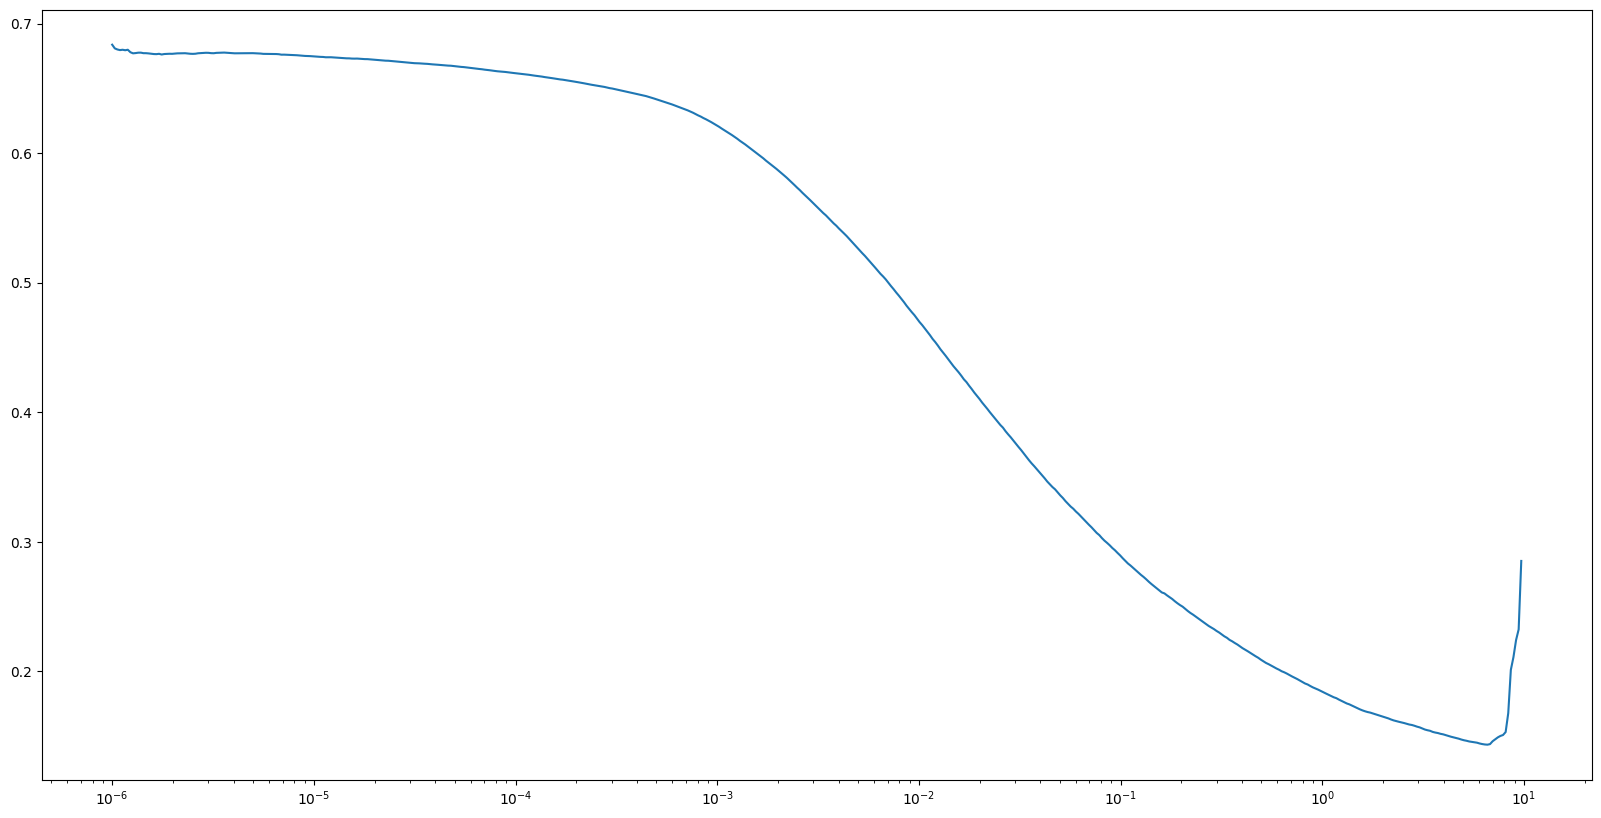

In [41]:
# plot loss vs learning rate
f1, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.show()

In [47]:
# entrenamos con el valor en x (learning rate) más bajo como max_lr 
torch.manual_seed(42)
model = UNET(3, 4, 2)
epochs = 5
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet, 
                                                max_lr = 10,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [48]:
# Aquí está lo chido! 
train(model, optimiser_unet, scheduler, epochs)

epoch: 0, mb: 25, train cost: 0.5039, val cost: 0.3941,train acc: 0.7559, val acc: 0.7740,dice: 0.005757711827754974, iou: 0.002887167502194643
epoch: 0, mb: 50, train cost: 0.4133, val cost: 0.2595,train acc: 0.8093, val acc: 0.9097,dice: 0.780451238155365, iou: 0.6399508118629456
epoch: 0, mb: 75, train cost: 0.3453, val cost: 0.1715,train acc: 0.8468, val acc: 0.9340,dice: 0.8495482206344604, iou: 0.7384474277496338
epoch: 0, mb: 100, train cost: 0.2989, val cost: 0.1444,train acc: 0.8697, val acc: 0.9421,dice: 0.8771628737449646, iou: 0.7812022566795349
epoch: 0, mb: 125, train cost: 0.2659, val cost: 0.1258,train acc: 0.8854, val acc: 0.9508,dice: 0.8840910792350769, iou: 0.792261004447937
epoch: 0, mb: 150, train cost: 0.2415, val cost: 0.1188,train acc: 0.8969, val acc: 0.9555,dice: 0.8957918286323547, iou: 0.8112527132034302
epoch: 0, mb: 175, train cost: 0.2241, val cost: 0.1125,train acc: 0.9054, val acc: 0.9594,dice: 0.9112868905067444, iou: 0.8370312452316284
epoch: 0, mb: 

In [85]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 224, 224]             112
   Conv_kernel_3_3-2          [-1, 4, 224, 224]               0
       BatchNorm2d-3          [-1, 4, 224, 224]               8
              ReLU-4          [-1, 4, 224, 224]               0
            Conv2d-5          [-1, 4, 224, 224]             148
   Conv_kernel_3_3-6          [-1, 4, 224, 224]               0
       BatchNorm2d-7          [-1, 4, 224, 224]               8
              ReLU-8          [-1, 4, 224, 224]               0
      Conv_2_capas-9          [-1, 4, 224, 224]               0
        MaxPool2d-10          [-1, 4, 112, 112]               0
           Conv2d-11          [-1, 8, 112, 112]             296
  Conv_kernel_3_3-12          [-1, 8, 112, 112]               0
      BatchNorm2d-13          [-1, 8, 112, 112]              16
             ReLU-14          [-1, 8, 1

In [88]:
#Almacenemos el modelo para posterior uso (inferencia)
torch.save(model.state_dict(), "../pickles/model_segmentation")

In [90]:
model_segmentation = UNET(3, 4, 2)
model_segmentation.load_state_dict(torch.load("../pickles/model_segmentation"))
#Verifiquemos el diccionario de estado del modelo que almacenamos y cargamos
print("Diccionario del Estado del Modelo")
for param_tensor in model_segmentation.state_dict():
    print(param_tensor, "\t", model_segmentation.state_dict()[param_tensor].size())

Diccionario del Estado del Modelo
first_conv.double_conv.0.conv1.weight 	 torch.Size([4, 3, 3, 3])
first_conv.double_conv.0.conv1.bias 	 torch.Size([4])
first_conv.double_conv.1.weight 	 torch.Size([4])
first_conv.double_conv.1.bias 	 torch.Size([4])
first_conv.double_conv.1.running_mean 	 torch.Size([4])
first_conv.double_conv.1.running_var 	 torch.Size([4])
first_conv.double_conv.1.num_batches_tracked 	 torch.Size([])
first_conv.double_conv.3.conv1.weight 	 torch.Size([4, 4, 3, 3])
first_conv.double_conv.3.conv1.bias 	 torch.Size([4])
first_conv.double_conv.4.weight 	 torch.Size([4])
first_conv.double_conv.4.bias 	 torch.Size([4])
first_conv.double_conv.4.running_mean 	 torch.Size([4])
first_conv.double_conv.4.running_var 	 torch.Size([4])
first_conv.double_conv.4.num_batches_tracked 	 torch.Size([])
down_conv1.encoder.1.double_conv.0.conv1.weight 	 torch.Size([8, 4, 3, 3])
down_conv1.encoder.1.double_conv.0.conv1.bias 	 torch.Size([8])
down_conv1.encoder.1.double_conv.1.weight 	 tor

# Mostrar predicciones del dataset de prueba


In [51]:
test_set = Car_Dataset(TEST_PATH, img_transforms=transform_data)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([32, 224, 224])


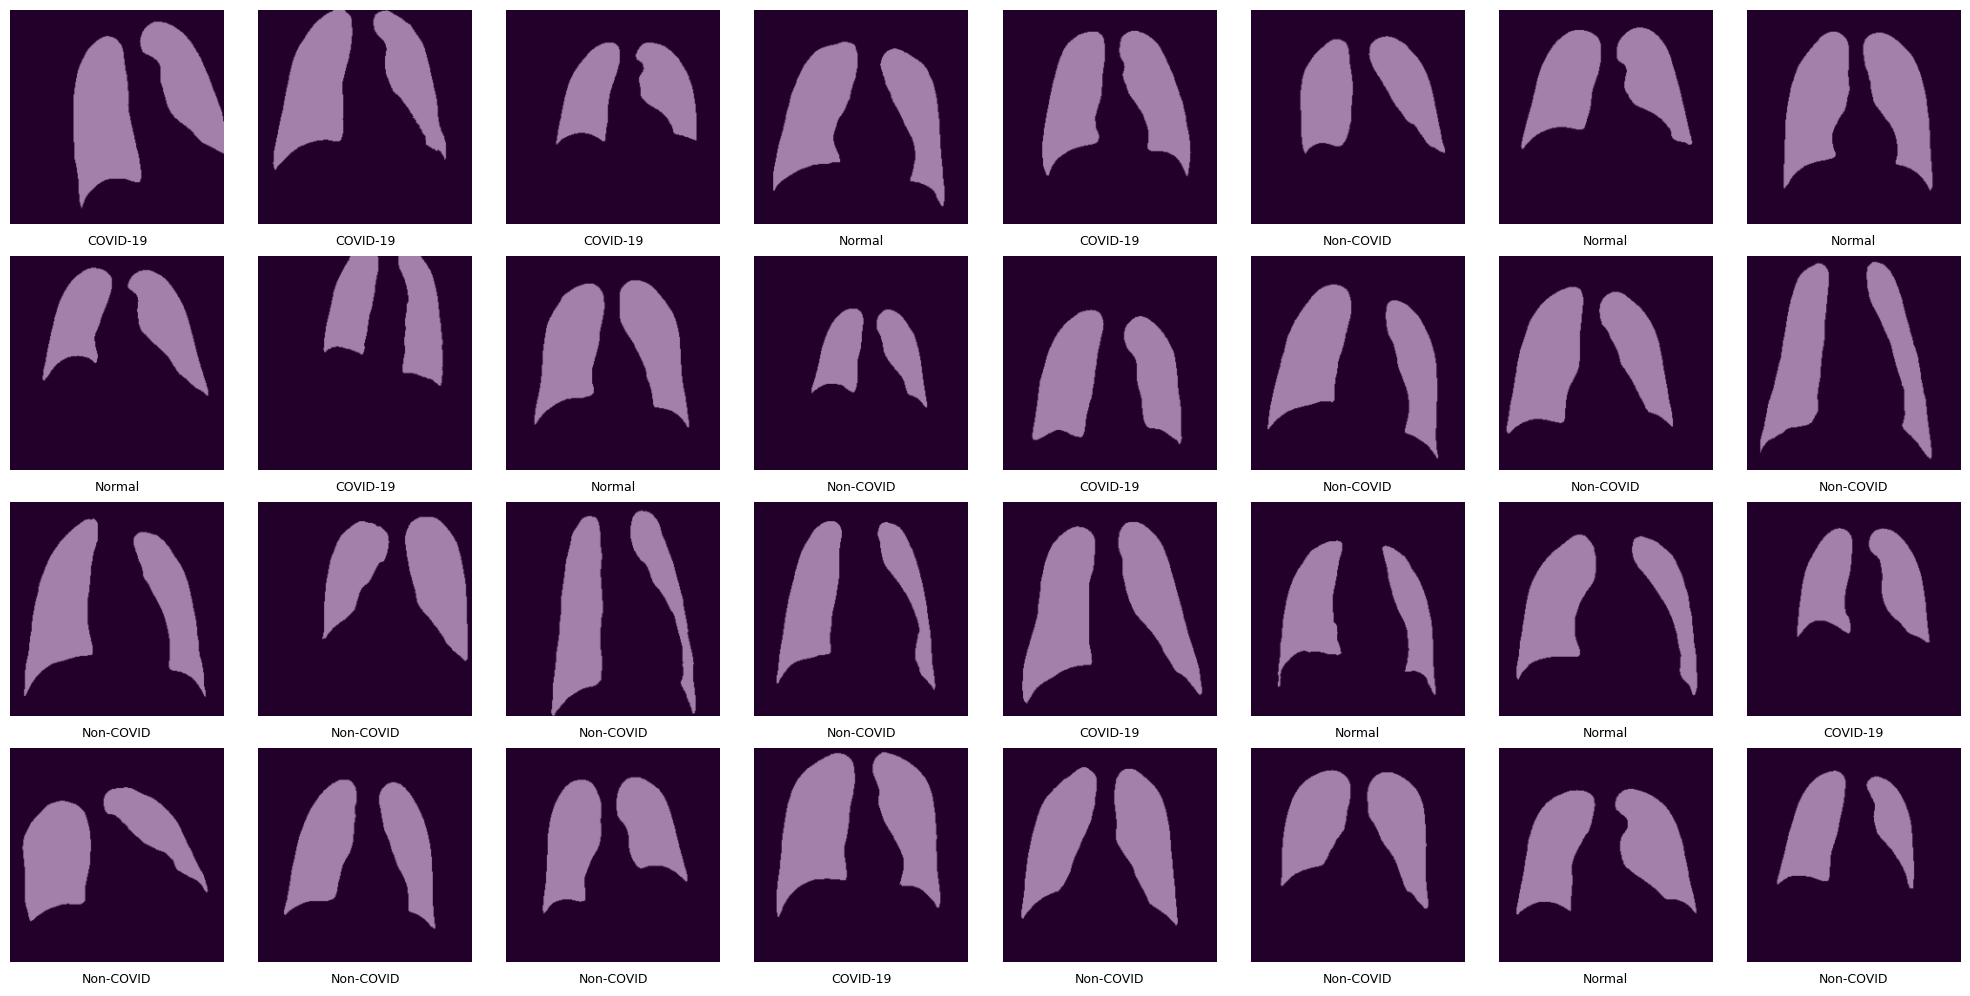

In [91]:
imgs_test, keys = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)
model_segmentation = model_segmentation.to(device)
with torch.no_grad():
    scores = model_segmentation(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_test, preds.unsqueeze(1), keys)

# Segundo modelo, clasificación

In [113]:
# Importamos los módulos necesarios de PyTorch.
import torch.nn as nn
import torch

class MyConvNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # Definición de capas convolucionales
        self.conv_layer_01 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3))
        self.conv_layer_02 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(5, 5))
        self.conv_layer_03 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=(3, 3))

        # Definamos las capas para el perceptrón multicapa
        # Full connect
        # Podemos esperar a saber el shape
        self.fc_layer_05 = nn.Linear(input_size, 11)
        self.fc_layer_06 = nn.Linear(11, 5) # capas ocultas
        self.fc_layer_07 = nn.Linear(5, 1) # capas ocultas. 


    def forward(self, x):
        # Crear la instancia e invocar el forward
        out_layer_01  = nn.ReLU()(self.conv_layer_01(x)) # Forward
        out_layer_02  = nn.Sigmoid()(self.conv_layer_02(out_layer_01)) # Forward
        out_layer_03  = nn.ReLU()(self.conv_layer_03(out_layer_02)) # Forward
        out_layer_04  = nn.Flatten()(out_layer_03)
        out_layer_05  = nn.ReLU()(self.fc_layer_05(out_layer_04)) 
        out_layer_06  = nn.ReLU()(self.fc_layer_06(out_layer_05)) 
        out_layer_07  = self.fc_layer_07(out_layer_06)
        return out_layer_07

In [115]:
import torchvision.transforms as transforms
TRAIN_PATH = {
        "COVID-19": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\COVID-19\images",
        "Non-COVID": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\Non-COVID\images",
        "Normal": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\Normal\images"
}

conv_class_trans = transforms.Compose([
            transforms.Resize([100,100]),
            transforms.RandomHorizontalFlip(),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize(mean=0.5, std=0.5)
        ])

train_set = Car_Dataset(TRAIN_PATH, img_transforms=conv_class_trans)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

for i in range(2):
  batch_x, batch_y = next(iter(train_loader))
  print(np.shape(batch_x), batch_y)

torch.Size([32, 1, 100, 100]) tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 0, 2, 1, 1, 0, 2, 0, 2, 1, 2, 0, 0,
        1, 2, 1, 0, 2, 0, 1, 0])
torch.Size([32, 1, 100, 100]) tensor([1, 0, 0, 2, 2, 2, 1, 1, 2, 0, 1, 0, 2, 1, 0, 2, 1, 1, 1, 0, 1, 2, 0, 0,
        1, 1, 0, 1, 2, 1, 0, 0])


torch.Size([32, 1, 100, 100]) tensor([0, 1, 2, 2, 0, 2, 1, 2, 2, 2, 0, 2, 1, 1, 1, 2, 1, 2, 0, 0, 2, 1, 1, 2,
        1, 2, 2, 0, 0, 0, 1, 2])
torch.Size([32, 1, 100, 100]) tensor([1, 0, 1, 2, 2, 1, 2, 2, 0, 0, 0, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 0,
        2, 0, 0, 1, 2, 2, 1, 2])


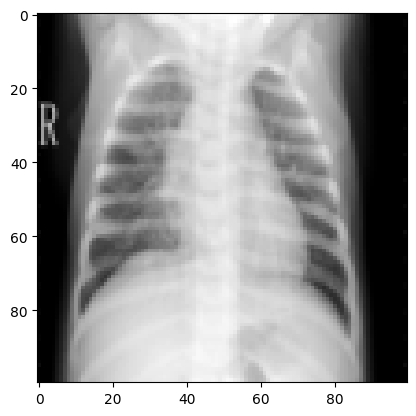

In [118]:
def show_image(tensor):
  img=tensor.numpy()
  img=np.squeeze(img, axis = 0)
  plt.imshow(img, cmap='gray')

for i in range(2):
  batch_x, batch_y = next(iter(train_loader))
  print(np.shape(batch_x), batch_y)
tensor = batch_x[0]
show_image(tensor)

In [117]:
# Parámetros del modelo
input_size = 248*248  # Tamaño de entrada, por ejemplo, para imágenes MNIST 248*248

# Instanciación del modelo
conv_classifier_model = MyConvNet(input_size)
conv_classifier_model = conv_classifier_model.to(device=device)

# Asegúrate de que tanto el modelo como los datos estén en el mismo dispositivo (CPU o CUDA)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definición de la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss() # Función de pérdida de entropía cruzada, adecuada para clasificación
# lr = learning rate
optimizer = torch.optim.Adam(conv_classifier_model.parameters(), lr=0.001) # Optimizador Adam

# Entrenamiento del modelo
num_epochs = 20

losses = []  # Lista para almacenar las pérdidas

for epoch in range(num_epochs):
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device=device, dtype=torch.float32)
        labels = labels.to(device)
        outputs = conv_classifier_model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

RuntimeError: Given groups=1, weight of size [16, 3, 3, 3], expected input[32, 1, 100, 100] to have 3 channels, but got 1 channels instead